In this notebook, we are going to train deep learning model for multiple classes of plants such as potatos, tomatoes and bell pepper

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers

import matplotlib.pyplot as plt

2024-01-17 18:43:24.654467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 18:43:25.847756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# define the image size and the batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data_1",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)


Found 20638 files belonging to 15 classes.


2024-01-17 18:43:35.181462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 18:43:35.459990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 18:43:35.460320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset) 


645

2024-01-17 18:43:36.939653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]
2024-01-17 18:43:36.940371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]


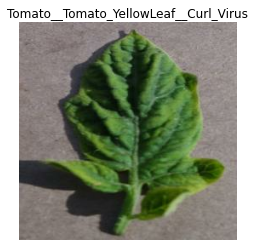

In [6]:
for image_batch, label_batch in dataset.take(1): # take any 1 image randomly
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])
    plt.show()

2024-01-17 18:43:37.391014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]
2024-01-17 18:43:37.391498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]


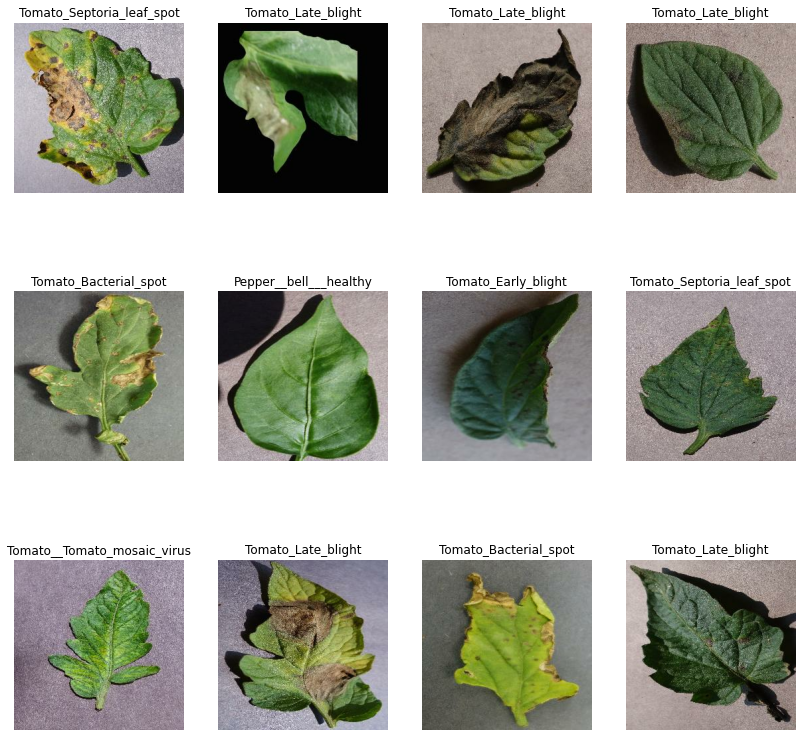

In [7]:
plt.figure(figsize=(14,14))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [8]:
# performing train test split
train_size = 0.8
len(dataset)*train_size

516.0

In [9]:
train_dataset = dataset.take(516)
len(train_dataset)

516

In [10]:
remaining = dataset.skip(516)
val_size = 0.1
len(dataset)*val_size

64.5

In [11]:
# validation dataset
val_dataset = remaining.take(65)

In [12]:
test_ds = remaining.skip(65)
len(test_ds)

64

In [13]:
# creating a pipeline function to perform all the above stpes together
def create_train_test_split(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(dataset)

    if shuffle:
        ds = dataset.shuffle(shuffle_size,seed=42)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = dataset.take(train_size)

    val_ds = dataset.skip(train_size).take(val_size)

    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds,val_ds,test_ds = create_train_test_split(dataset)

print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

516
65
64


In [14]:
# image preprocessing and augmentation
resize_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomContrast(factor=(0.5,1.5))
    ]
)


# Model Training

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 15

model = models.Sequential(
    [
        resize_rescale,
        data_augmentation,

        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='softmax')

    ]
)

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
with tf.device('/device:GPU:0'): # only run with this if you have gpu device available. else just remove the with statement and the later indentation.
    history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose=1,
        validation_data = val_ds
    )

Epoch 1/40


2024-01-17 18:43:51.701032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]
2024-01-17 18:43:51.701769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]
2024-01-17 18:43:55.111503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-17 18:43:56.473601: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55970423f4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2

516/516 [==============================] - ETA: 0s - loss: 2.0616 - accuracy: 0.3141

2024-01-17 18:44:51.308328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]
2024-01-17 18:44:51.308680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]


516/516 [==============================] - 71s 121ms/step - loss: 2.0616 - accuracy: 0.3141 - val_loss: 1.5759 - val_accuracy: 0.4775
Epoch 2/40
516/516 [==============================] - 61s 117ms/step - loss: 1.2137 - accuracy: 0.5914 - val_loss: 1.0320 - val_accuracy: 0.6509
Epoch 3/40
516/516 [==============================] - 58s 113ms/step - loss: 0.8491 - accuracy: 0.7140 - val_loss: 0.7901 - val_accuracy: 0.7402
Epoch 4/40
516/516 [==============================] - 60s 117ms/step - loss: 0.7272 - accuracy: 0.7511 - val_loss: 0.7305 - val_accuracy: 0.7476
Epoch 5/40
516/516 [==============================] - 63s 121ms/step - loss: 0.6196 - accuracy: 0.7925 - val_loss: 0.6906 - val_accuracy: 0.7495
Epoch 6/40
516/516 [==============================] - 61s 118ms/step - loss: 0.5644 - accuracy: 0.8070 - val_loss: 0.9562 - val_accuracy: 0.6562
Epoch 7/40
516/516 [==============================] - 62s 119ms/step - loss: 0.5121 - accuracy: 0.8238 - val_loss: 0.7475 - val_accuracy: 0.7

In [19]:
scores = model.evaluate(test_ds)


2024-01-17 19:29:06.134747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]
2024-01-17 19:29:06.135942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20638]
	 [[{{node Placeholder/_4}}]]


65/65 [==============================] - 12s 60ms/step - loss: 0.2406 - accuracy: 0.9254


In [20]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 516}

In [21]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history.history['accuracy']


[0.3141351640224457,
 0.5913881063461304,
 0.7139655947685242,
 0.7510901093482971,
 0.792453944683075,
 0.8069888353347778,
 0.8237645626068115,
 0.8445978760719299,
 0.8493822813034058,
 0.864098846912384,
 0.8794816136360168,
 0.8805111646652222,
 0.8887475728988647,
 0.8882025480270386,
 0.8976501822471619,
 0.8994670510292053,
 0.8960756063461304,
 0.9088541865348816,
 0.9074006676673889,
 0.9123667478561401,
 0.9121850728988647,
 0.9161216020584106,
 0.9209060072898865,
 0.9246003031730652,
 0.9202398061752319,
 0.927204430103302,
 0.9230862259864807,
 0.9275678396224976,
 0.932473361492157,
 0.926598846912384,
 0.929384708404541,
 0.935259222984314,
 0.9337451457977295,
 0.9342902302742004,
 0.939740777015686,
 0.9364704489707947,
 0.9367126822471619,
 0.9436773061752319,
 0.9428900480270386,
 0.9474321603775024]

In [23]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

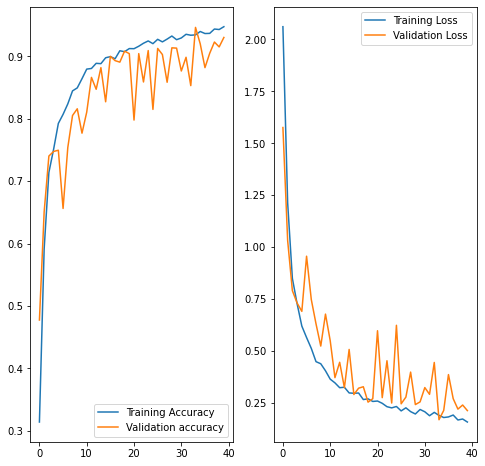

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend()

2024-01-17 19:29:49.582475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]
2024-01-17 19:29:49.583296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20638]
	 [[{{node Placeholder/_0}}]]


Actual Label:  Potato___Late_blight
1/1 [==============================] - 0s 42ms/step
Predicted Label:  Potato___Late_blight


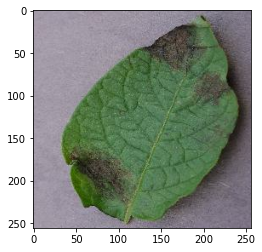

In [26]:
# making predictions on sample image

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("Actual Label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [27]:
# saving the model 

model_version=1
model.save(f"multiplant_models/{model_version}")

2024-01-17 19:30:39.754592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_input}}]]
2024-01-17 19:30:39.921870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2024-01-17 19:30:39.942567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: multiplant_models/1/assets


INFO:tensorflow:Assets written to: multiplant_models/1/assets
